# Idea behind Nonlinear SNR 
When two sites are connected by fiber, the noise to signal ratio (NSR=1/SNR) at the end of the span depends on two things; the amount of "linear noise" added by the amplifiers and the "nonlinear noise" created when the power of the signal modulates and thus distorts the signal itself. 

$\quad$

Computing the effect of linear noise is easy since it only depends on the characteristics of the amplifiers. But how do we calculate the nonlinear noise?

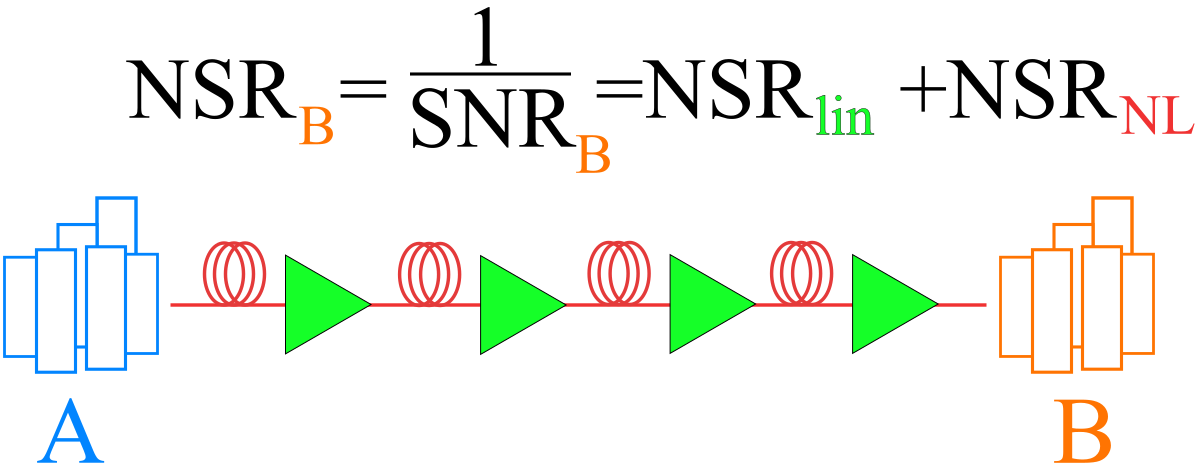

In [1]:
from ssfm_functions import *
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Initialize timebase:
N  = 2**18 #Number of points
dt = 0.05e-12 #Time resolution [s] 

centerWavelength = 1550e-9 #laser wl in m  
centerFreq_test=wavelengthToFreq(centerWavelength)

timeFreq_test=timeFreq_class(N,dt,centerFreq_test)

 ### timeFreq Configuration Parameters ###
  Number of points 		= 262144
  Start time, tmin 		= -6553.600ps
  Stop time, tmax 		= 6553.600ps
  Time resolution 		= 0.050ps
  
  Center frequency		= 193.414THz
  Start frequency		= -10.000THz
  Stop frequency 		= 10.000THz
  Frequency resolution 		= 76.294MHz
   


In [3]:
#Initialize signal

testAmplitude = np.sqrt(1/1e3)     #Amplitude in units of sqrt(W)
testDuration  =50e-12              #Pulse duration [s]
testTimeOffset    = 0              #Time offset
testFreqOffset    = 0              #Freq offset from center frequency

testChirp = 0
testPulseType='custom' 
testOrder = 1
testNoiseAmplitude = 0

#Define empty signal as we want to fill it out with specific channels later
testInputSignal = input_signal_class(timeFreq_test, 
                                      0 ,
                                      0,
                                      0,
                                      0,                                        
                                      0,
                                      testPulseType,
                                      0,
                                      0)

#Define channel spacing and number of channels in the C-band. 
channel_spacing_Hz = 120e9
Nchannels = 40
channel_list = [None]*Nchannels



for channel_index in range(Nchannels):
    #Define min, center and max freq of channel
    channelFreqCenter_Hz = freq_min_Cband_Hz+channel_spacing_Hz*(0.5+channel_index)
    channelFreqMin_Hz    = channelFreqCenter_Hz-channel_spacing_Hz/2
    channelFreqMax_Hz    = channelFreqCenter_Hz+channel_spacing_Hz/2

    #Initialize channel and store in list
    currentChannel = channel_class(channelFreqCenter_Hz, channelFreqMin_Hz, channelFreqMax_Hz)
    channel_list[channel_index]=currentChannel

    #Create a sinc-shaped pulse with a carrier freq at the center of the channel 
    testInputSignal.amplitude += getPulse(timeFreq_test.t, 
                                          testAmplitude, 
                                          testDuration, 
                                          testTimeOffset,
                                          timeFreq_test.centerFrequency-currentChannel.centerFreq_Hz,                                        
                                          testChirp,
                                          'sinc',
                                          testOrder,
                                          testNoiseAmplitude)
testInputSignal.update_spectrum() #Re-calculate the spectrum
testInputSignal.duration = testDuration

 ### Input Signal Parameters ###
  Pmax 				= 0.000 W
  Duration 			= 0.000 ps
  Time offset 			= 0.000 ps
  Freq offset 			= 0.000 GHz
  Chirp 			= 0.000
  pulseType 			= custom
  order 			= 0
  noiseAmplitude 		= 0.000 sqrt(W)
   


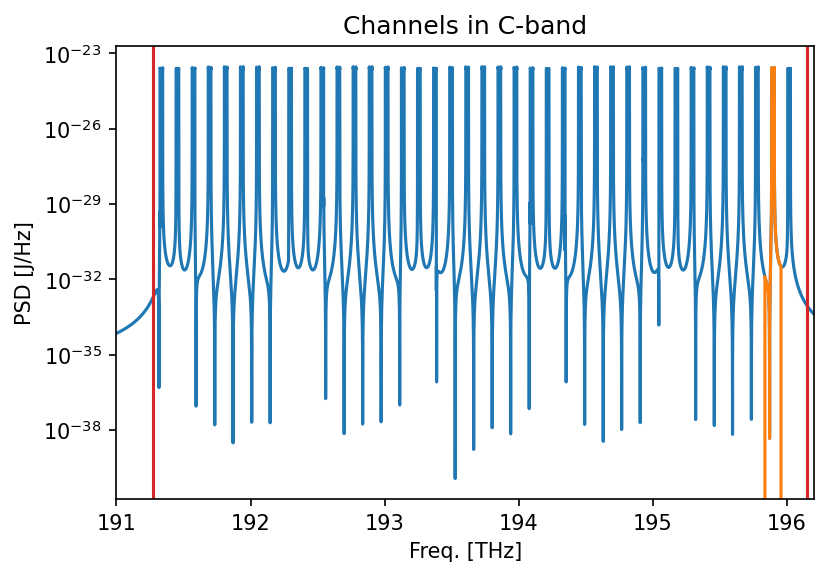

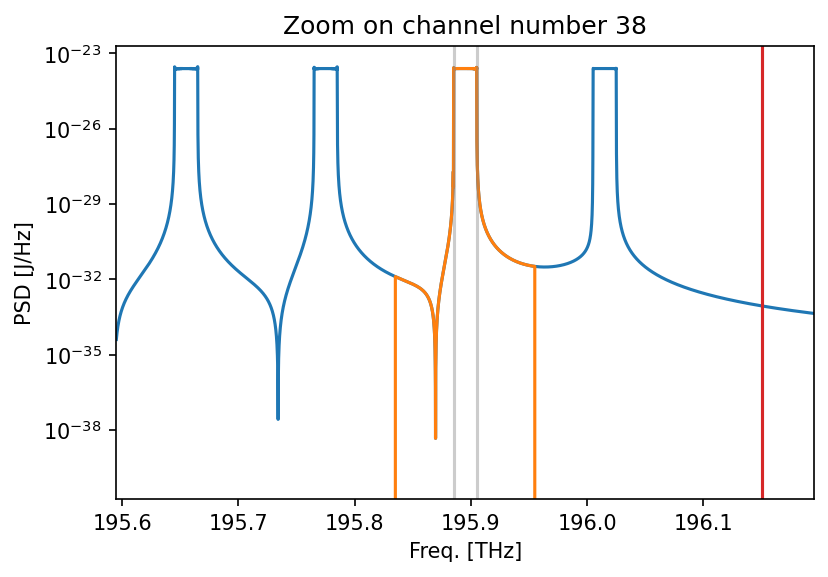

In [4]:
#Pick a channel to plot
testChannel =38

fig,ax=plt.subplots(dpi=150)
ax.set_title('Channels in C-band')
ax.plot(testInputSignal.timeFreq.f/1e12+testInputSignal.timeFreq.centerFrequency/1e12,getPower(testInputSignal.spectrum))
ax.plot(testInputSignal.timeFreq.f/1e12+testInputSignal.timeFreq.centerFrequency/1e12,getPower(extractSpectrumRange(testInputSignal.timeFreq.f/1e12+testInputSignal.timeFreq.centerFrequency/1e12, testInputSignal.spectrum,channel_list[testChannel].minFreq_Hz/1e12,channel_list[testChannel].maxFreq_Hz/1e12)))
ax.axvline(x=freq_min_Cband_Hz/1e12,color='C3')
ax.axvline(x=freq_max_Cband_Hz/1e12,color='C3')
ax.set_xlim(191,196.2)
ax.set_xlabel('Freq. [THz]')
ax.set_ylabel('PSD [J/Hz]')
ax.set_yscale('log')
plt.show()

fig,ax=plt.subplots(dpi=150)
ax.set_title(f'Zoom on channel number {testChannel}')

ax.plot(testInputSignal.timeFreq.f/1e12+testInputSignal.timeFreq.centerFrequency/1e12,getPower(testInputSignal.spectrum))
ax.plot(testInputSignal.timeFreq.f/1e12+testInputSignal.timeFreq.centerFrequency/1e12,getPower(extractSpectrumRange(testInputSignal.timeFreq.f/1e12+testInputSignal.timeFreq.centerFrequency/1e12, testInputSignal.spectrum,channel_list[testChannel].minFreq_Hz/1e12,channel_list[testChannel].maxFreq_Hz/1e12)))
ax.axvline(x=freq_min_Cband_Hz/1e12,color='C3')
ax.axvline(x=freq_max_Cband_Hz/1e12,color='C3')
ax.axvline(x=(channel_list[testChannel].centerFreq_Hz-1/testDuration/2)/1e12,color='gray',alpha=0.4)
ax.axvline(x=(channel_list[testChannel].centerFreq_Hz+1/testDuration/2)/1e12,color='gray',alpha=0.4)
ax.set_yscale('log')
ax.set_xlabel('Freq. [THz]')
ax.set_ylabel('PSD [J/Hz]')
ax.set_xlim(channel_list[testChannel].minFreq_Hz/1e12-2*channel_spacing_Hz/1e12,channel_list[testChannel].maxFreq_Hz/1e12+2*channel_spacing_Hz/1e12)
plt.show()


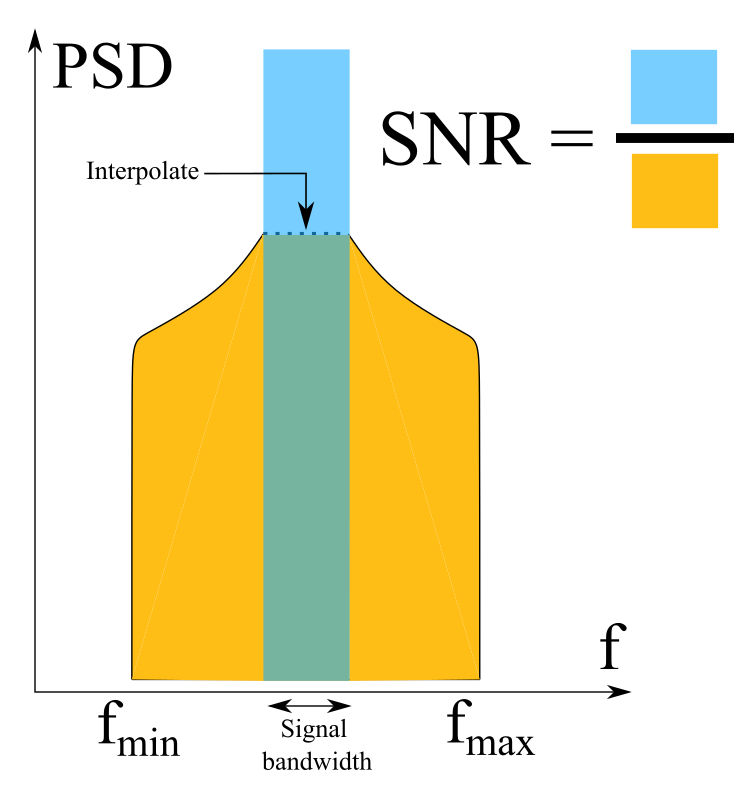

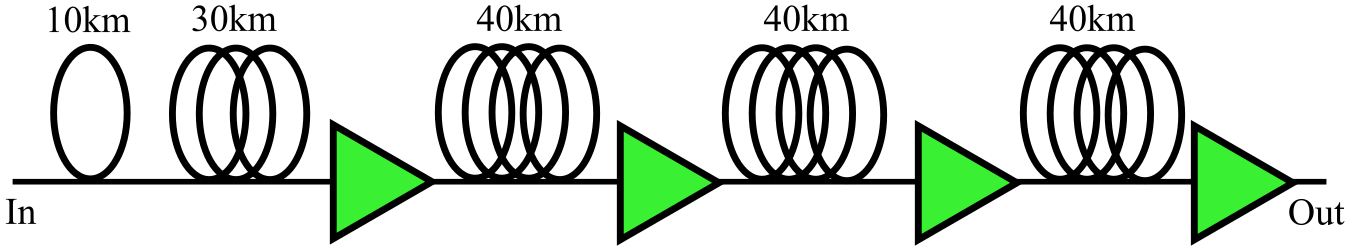

In [5]:
#Initialize fibers

beta2 = -1e-27 # s^2/m Typical GVD at 1550nm for a low dispersion fiber
beta_list = [beta2] #Dispersion in units of s^(entry+2)/m    

fiber_diameter = 8.4e-6 #m
n2_silica=2.2e-20 #m**2/W
gamma_test = getGammaFromFiberParams(centerWavelength,n2_silica,fiber_diameter)

#  Initialize fibers
alpha_test = 0.22/1e3
length_test=40e3  #40 km fiber
spanloss=alpha_test*length_test #Total loss in 40km of fiber

firstSegment = 10e3 #Create short "pseudo fiber" for the first few km as NL effects are very strong here

fiber1 = fiber_class(firstSegment,  #2km fiber
                         2**8,      #Many steps
                         gamma_test,   
                         beta_list,    
                         alpha_test, 
                         outputAmplification_dB=0  ) #No output amplification


fiber2 = fiber_class(length_test-firstSegment,     #Remaining 38km
                         2**8,                     #Few steps as NL effects smaller due to dispersion
                         gamma_test,   
                         beta_list,    
                         alpha_test, 
                         outputAmplification_dB=spanloss  ) #Output amplification compensates for total loss

fiber3 = fiber_class(length_test,  #40km fiber
                         2**8,     #Few steps
                         gamma_test,   
                         beta_list,    
                         alpha_test, 
                         outputAmplification_dB=spanloss  ) #Output amp.



fiber_list = [fiber1,fiber2,fiber3,fiber3,fiber3]
fiber_span = fiber_span_class(fiber_list)






 ### Characteristic parameters of fiber: ###
Fiber Length [km] 	= 10.0 
Number of Steps 	= 256 
dz [m] 	= 39.0625 
Fiber gamma [1/W/m] 	= 0.0016092458488771856 
Fiber beta2 [s^2/m] 	= -1e-27 
Fiber beta3 [s^3/m] 	= 0.0 
Fiber beta4 [s^4/m] 	= 0.0 
Fiber beta5 [s^5/m] 	= 0.0 
Fiber beta6 [s^6/m] 	= 0.0 
Fiber beta7 [s^7/m] 	= 0.0 
Fiber beta8 [s^8/m] 	= 0.0 
Fiber alpha_dB_per_m 	= 0.00022 
Fiber alpha_Np_per_m 	= 5.065687204586901e-05 
Fiber total loss [dB] 	= 2.2 
Raman Model 	= None. (fR,tau1,tau2)=(0.0,0.0,0.0) 
Output Amplification = 0 
 
 ### Characteristic parameters of fiber: ###
Fiber Length [km] 	= 30.0 
Number of Steps 	= 256 
dz [m] 	= 117.1875 
Fiber gamma [1/W/m] 	= 0.0016092458488771856 
Fiber beta2 [s^2/m] 	= -1e-27 
Fiber beta3 [s^3/m] 	= 0.0 
Fiber beta4 [s^4/m] 	= 0.0 
Fiber beta5 [s^5/m] 	= 0.0 
Fiber beta6 [s^6/m] 	= 0.0 
Fiber beta7 [s^7/m] 	= 0.0 
Fiber beta8 [s^8/m] 	= 0.0 
Fiber alpha_dB_per_m 	= 0.00022 
Fiber alpha_Np_per_m 	= 5.065687204586901e-05 
Fiber tota

########### Initializing SSFM!!! ###########
Current time is 2023-10-20 18:03:04.372923
Current dir is C:\Users\okrarup\OneDrive - Ciena Corporation\Desktop\SSFM folder\NLSE-vector-solver\Simulation Results\TelecomSim\2023_10_20_18_3_4\
Starting SSFM loop over 5 fibers
Propagating through fiber number 1 out of 5
Info about fiber
 ### Characteristic parameters of fiber: ###
Fiber Length [km] 	= 10.0 
Number of Steps 	= 256 
dz [m] 	= 39.0625 
Fiber gamma [1/W/m] 	= 0.0016092458488771856 
Fiber beta2 [s^2/m] 	= -1e-27 
Fiber beta3 [s^3/m] 	= 0.0 
Fiber beta4 [s^4/m] 	= 0.0 
Fiber beta5 [s^5/m] 	= 0.0 
Fiber beta6 [s^6/m] 	= 0.0 
Fiber beta7 [s^7/m] 	= 0.0 
Fiber beta8 [s^8/m] 	= 0.0 
Fiber alpha_dB_per_m 	= 0.00022 
Fiber alpha_Np_per_m 	= 5.065687204586901e-05 
Fiber total loss [dB] 	= 2.2 
Raman Model 	= None. (fR,tau1,tau2)=(0.0,0.0,0.0) 
Output Amplification = 0 
 
 
 ### Characteristic parameters of simulation: ###
  Length_fiber 	= 1.00e+01 km
  L_eff       	= 7.85e+00 km
  Length_

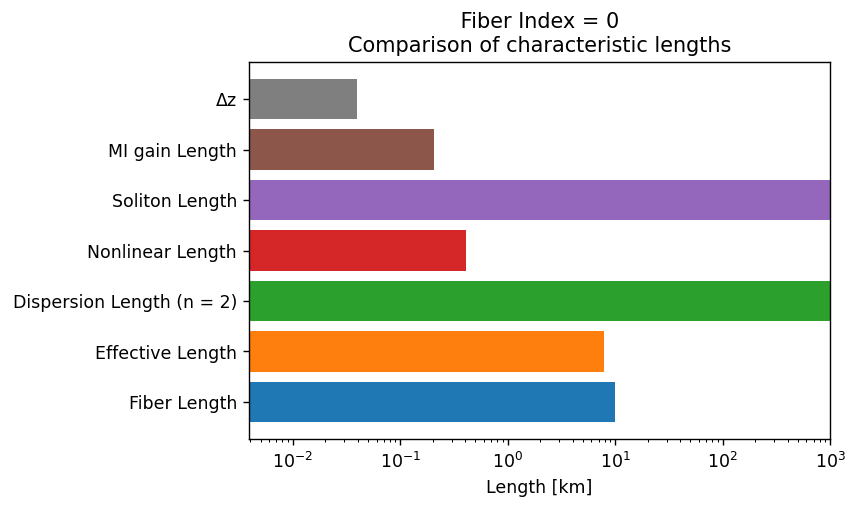

Running SSFM with 256 steps
SSFM progress through fiber number 1 = 10.00%
SSFM progress through fiber number 1 = 20.00%
SSFM progress through fiber number 1 = 30.00%
SSFM progress through fiber number 1 = 40.00%
SSFM progress through fiber number 1 = 50.00%
SSFM progress through fiber number 1 = 60.00%
SSFM progress through fiber number 1 = 70.00%
SSFM progress through fiber number 1 = 80.00%
SSFM progress through fiber number 1 = 90.00%
Propagating through fiber number 2 out of 5
Info about fiber
 ### Characteristic parameters of fiber: ###
Fiber Length [km] 	= 30.0 
Number of Steps 	= 256 
dz [m] 	= 117.1875 
Fiber gamma [1/W/m] 	= 0.0016092458488771856 
Fiber beta2 [s^2/m] 	= -1e-27 
Fiber beta3 [s^3/m] 	= 0.0 
Fiber beta4 [s^4/m] 	= 0.0 
Fiber beta5 [s^5/m] 	= 0.0 
Fiber beta6 [s^6/m] 	= 0.0 
Fiber beta7 [s^7/m] 	= 0.0 
Fiber beta8 [s^8/m] 	= 0.0 
Fiber alpha_dB_per_m 	= 0.00022 
Fiber alpha_Np_per_m 	= 5.065687204586901e-05 
Fiber total loss [dB] 	= 6.6000000000000005 
Raman Model

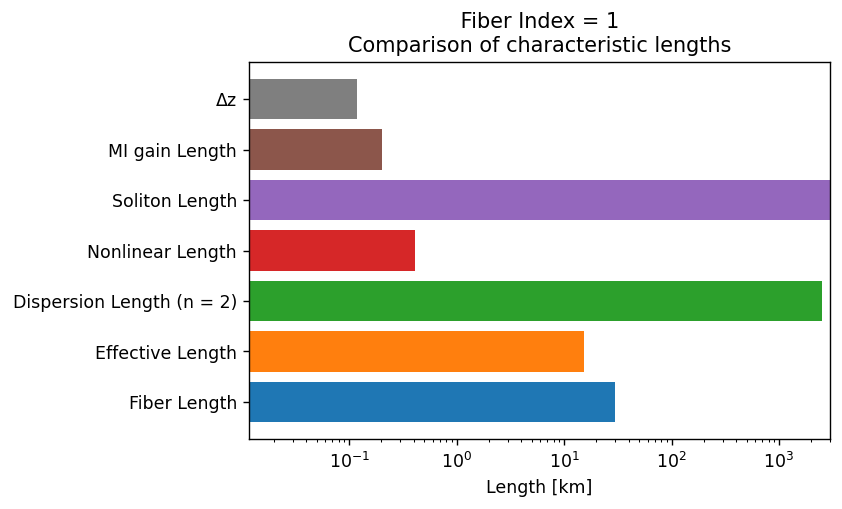

Running SSFM with 256 steps
SSFM progress through fiber number 2 = 10.00%
SSFM progress through fiber number 2 = 20.00%
SSFM progress through fiber number 2 = 30.00%
SSFM progress through fiber number 2 = 40.00%
SSFM progress through fiber number 2 = 50.00%
SSFM progress through fiber number 2 = 60.00%
SSFM progress through fiber number 2 = 70.00%
SSFM progress through fiber number 2 = 80.00%
SSFM progress through fiber number 2 = 90.00%
Propagating through fiber number 3 out of 5
Info about fiber
 ### Characteristic parameters of fiber: ###
Fiber Length [km] 	= 40.0 
Number of Steps 	= 256 
dz [m] 	= 156.25 
Fiber gamma [1/W/m] 	= 0.0016092458488771856 
Fiber beta2 [s^2/m] 	= -1e-27 
Fiber beta3 [s^3/m] 	= 0.0 
Fiber beta4 [s^4/m] 	= 0.0 
Fiber beta5 [s^5/m] 	= 0.0 
Fiber beta6 [s^6/m] 	= 0.0 
Fiber beta7 [s^7/m] 	= 0.0 
Fiber beta8 [s^8/m] 	= 0.0 
Fiber alpha_dB_per_m 	= 0.00022 
Fiber alpha_Np_per_m 	= 5.065687204586901e-05 
Fiber total loss [dB] 	= 8.8 
Raman Model 	= None. (fR,tau

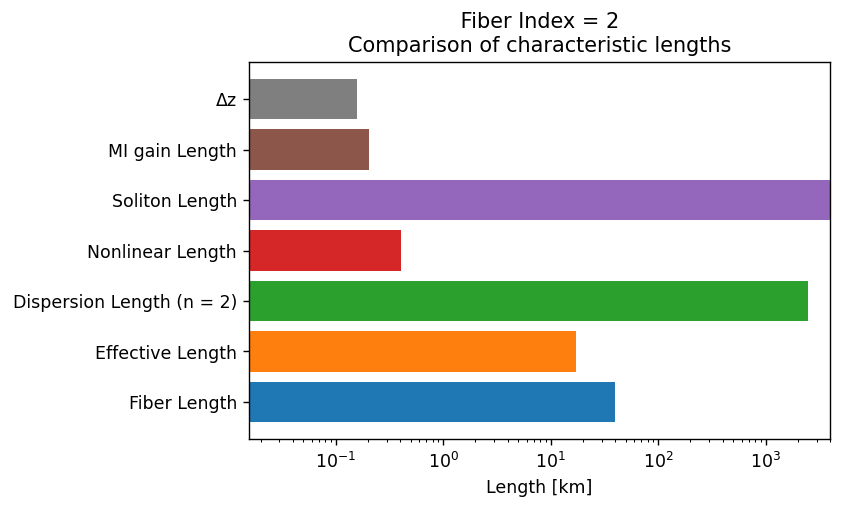

Running SSFM with 256 steps
SSFM progress through fiber number 3 = 10.00%
SSFM progress through fiber number 3 = 20.00%
SSFM progress through fiber number 3 = 30.00%
SSFM progress through fiber number 3 = 40.00%
SSFM progress through fiber number 3 = 50.00%
SSFM progress through fiber number 3 = 60.00%
SSFM progress through fiber number 3 = 70.00%
SSFM progress through fiber number 3 = 80.00%
SSFM progress through fiber number 3 = 90.00%
Propagating through fiber number 4 out of 5
Info about fiber
 ### Characteristic parameters of fiber: ###
Fiber Length [km] 	= 40.0 
Number of Steps 	= 256 
dz [m] 	= 156.25 
Fiber gamma [1/W/m] 	= 0.0016092458488771856 
Fiber beta2 [s^2/m] 	= -1e-27 
Fiber beta3 [s^3/m] 	= 0.0 
Fiber beta4 [s^4/m] 	= 0.0 
Fiber beta5 [s^5/m] 	= 0.0 
Fiber beta6 [s^6/m] 	= 0.0 
Fiber beta7 [s^7/m] 	= 0.0 
Fiber beta8 [s^8/m] 	= 0.0 
Fiber alpha_dB_per_m 	= 0.00022 
Fiber alpha_Np_per_m 	= 5.065687204586901e-05 
Fiber total loss [dB] 	= 8.8 
Raman Model 	= None. (fR,tau

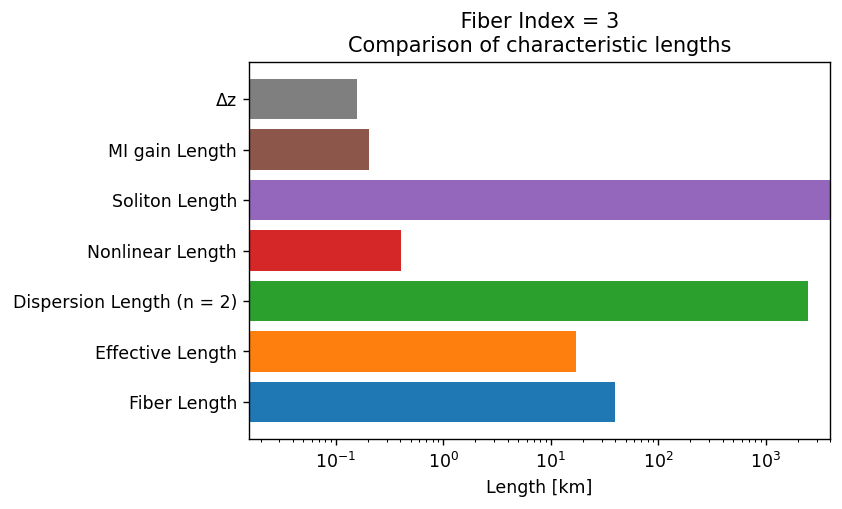

Running SSFM with 256 steps
SSFM progress through fiber number 4 = 10.00%
SSFM progress through fiber number 4 = 20.00%
SSFM progress through fiber number 4 = 30.00%
SSFM progress through fiber number 4 = 40.00%
SSFM progress through fiber number 4 = 50.00%
SSFM progress through fiber number 4 = 60.00%
SSFM progress through fiber number 4 = 70.00%
SSFM progress through fiber number 4 = 80.00%
SSFM progress through fiber number 4 = 90.00%
Propagating through fiber number 5 out of 5
Info about fiber
 ### Characteristic parameters of fiber: ###
Fiber Length [km] 	= 40.0 
Number of Steps 	= 256 
dz [m] 	= 156.25 
Fiber gamma [1/W/m] 	= 0.0016092458488771856 
Fiber beta2 [s^2/m] 	= -1e-27 
Fiber beta3 [s^3/m] 	= 0.0 
Fiber beta4 [s^4/m] 	= 0.0 
Fiber beta5 [s^5/m] 	= 0.0 
Fiber beta6 [s^6/m] 	= 0.0 
Fiber beta7 [s^7/m] 	= 0.0 
Fiber beta8 [s^8/m] 	= 0.0 
Fiber alpha_dB_per_m 	= 0.00022 
Fiber alpha_Np_per_m 	= 5.065687204586901e-05 
Fiber total loss [dB] 	= 8.8 
Raman Model 	= None. (fR,tau

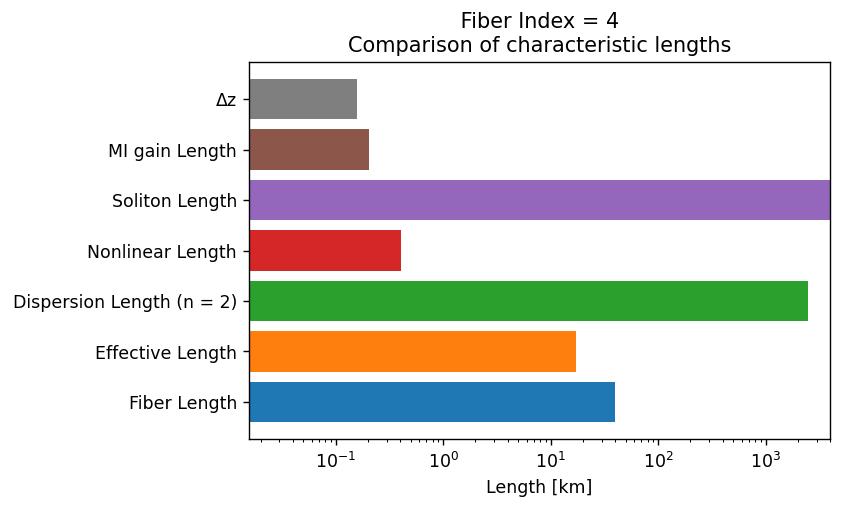

Running SSFM with 256 steps
SSFM progress through fiber number 5 = 10.00%
SSFM progress through fiber number 5 = 20.00%
SSFM progress through fiber number 5 = 30.00%
SSFM progress through fiber number 5 = 40.00%
SSFM progress through fiber number 5 = 50.00%
SSFM progress through fiber number 5 = 60.00%
SSFM progress through fiber number 5 = 70.00%
SSFM progress through fiber number 5 = 80.00%
SSFM progress through fiber number 5 = 90.00%
Finished running SSFM!!!


In [6]:
expName="TelecomSim"
#Run SSFM
ssfm_result_list = SSFM(fiber_span, 
                        testInputSignal,
                        showProgressFlag=True,
                        experimentName=expName,
                        FFT_tol=5e-5)





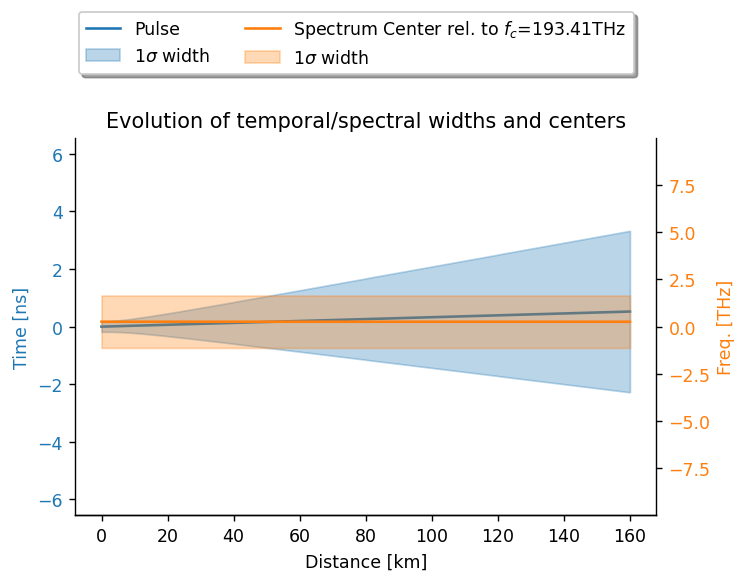

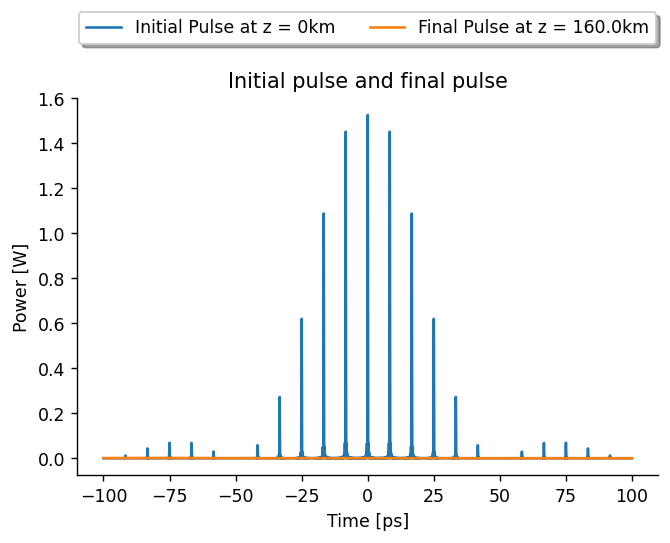

length of zvals = 1281


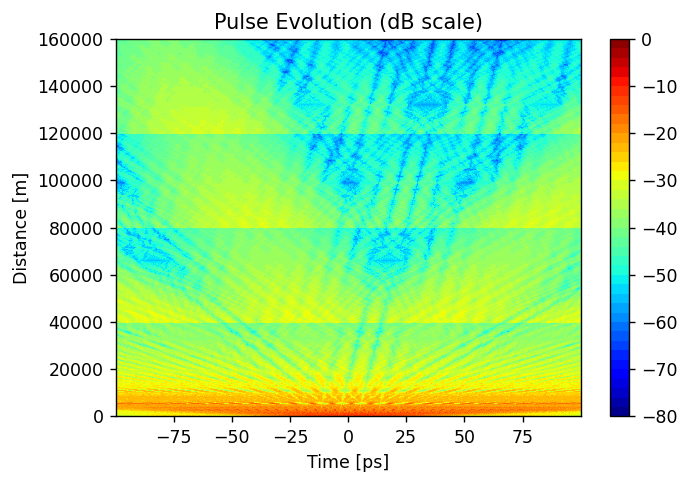

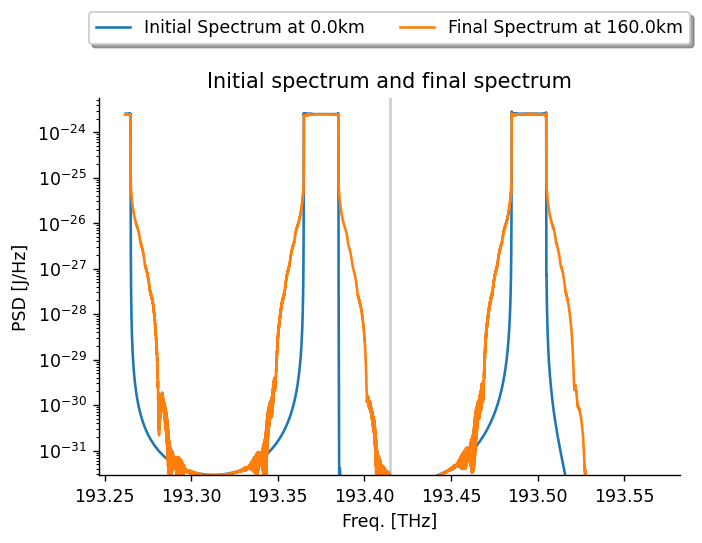

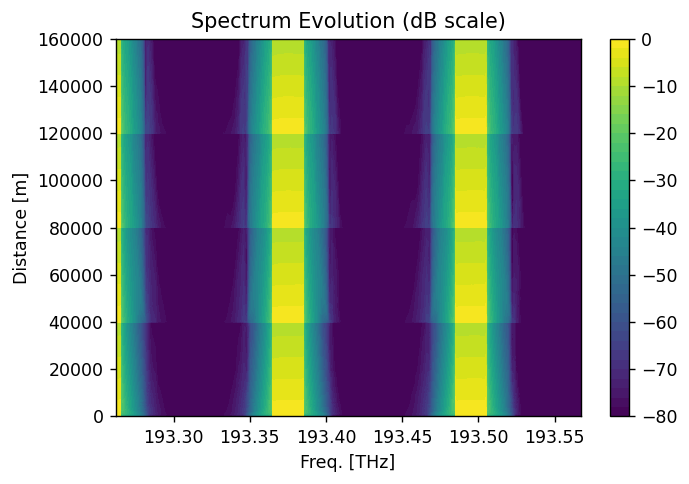

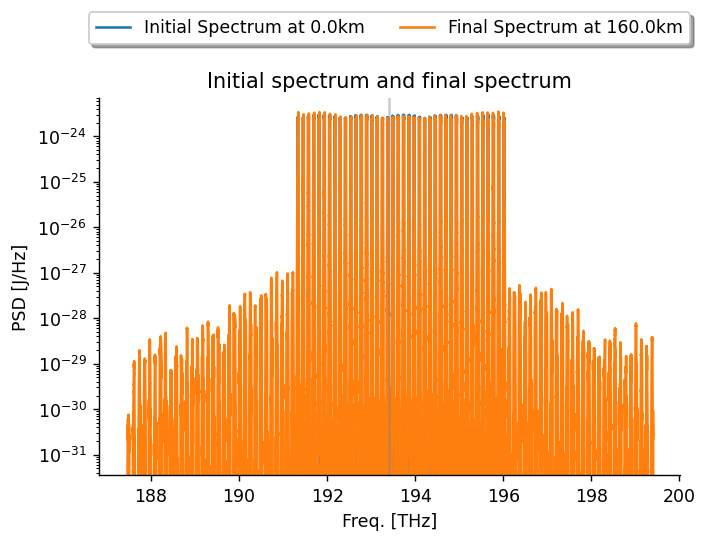

In [7]:
#Plot pulses
nrange_test_pulse=2000
cutoff_test_pulse=-80

#Plot spectrum
nrange_test_spectrum=int(2000)
cutoff_test_spectrum=-80


plotEverythingAboutResult(ssfm_result_list,
                          nrange_test_pulse,
                          cutoff_test_pulse,
                          nrange_test_spectrum,
                          cutoff_test_spectrum,
                          skip_chirp_plot_flag = True
                          )

plotFirstAndLastSpectrum(ssfm_result_list, int(len(testInputSignal.timeFreq.t)*0.3), cutoff_test_spectrum)



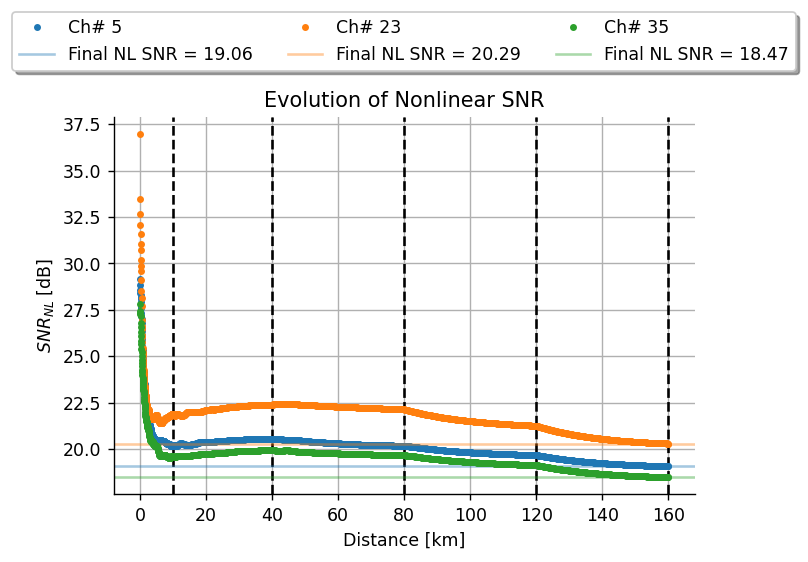

In [8]:
    plotSNR_NLforChannels(ssfm_result_list,
                         channel_list,
                         [5,23,35],
                         1/testDuration) 
    






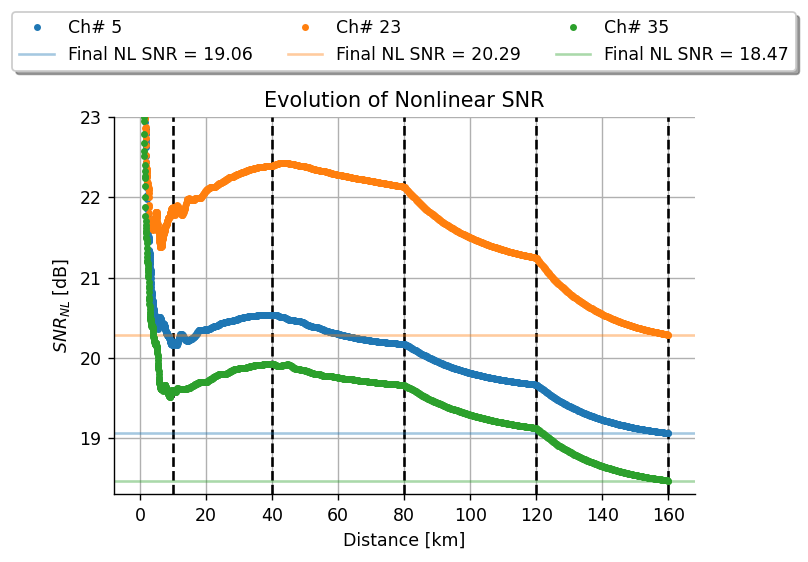

In [11]:
    plotSNR_NLforChannels(ssfm_result_list,
                         channel_list,
                         [5,23,35],
                         1/testDuration,
                         ylims=(18.3,23)) 

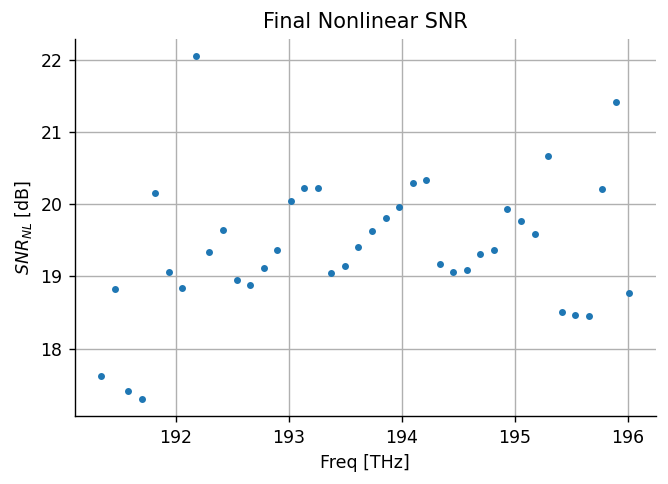

In [10]:
    plotFinalSNR_dB(ssfm_result_list,
                     channel_list,
                     1/testDuration)

# Comment
Using the split step method can give results that closely match experimental ones, but is computationally inefficient, which problematic when simulating large networks with many links. Under certain assumptions and approximations, analytical expressions for the nonlinear noise can be derived and evaluated much more quickly:
https://arxiv.org/ftp/arxiv/papers/1209/1209.0394.pdf



